In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision import transforms
import numpy as np
from matplotlib import pyplot as plt
from collections import namedtuple
import functools
import glob
import os
import csv
import SimpleITK as sitk
from torch.utils.data import Dataset
import copy
from util.logconf import logging
from util.disk import getCache, DataUnversionedPath, DataPath
raw_cache = getCache('part2ch10_raw')

log = logging.getLogger(__name__)
# log.setLevel(logging.WARN)
# log.setLevel(logging.INFO)
log.setLevel(logging.DEBUG)

IrcTuple = namedtuple('IrcTuple', ['index', 'row', 'col'])
XyzTuple = namedtuple('XyzTuple', ['x', 'y', 'z'])
CandidateInfoTuple = namedtuple('CandidateInfoTuple',
                                'isNodule_bool, diameter_mm, series_uid, center_xyz')

def irc2xyz(coord_irc, origin_xyz, vxSize_xyz, direction_a):
    # Flip the coordinates from IRC to CRI, to align with XYZ.
    cri_a = np.array(coord_irc)[::-1]
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    # Scale the indices with the voxel sizes.
    # Matrix-multiply with the directions matrix, using @ in Python.
    # Add the offset for the origin.
    coords_xyz = (direction_a @ (cri_a * vxSize_a)) + origin_a
    return XyzTuple(*coords_xyz)

def xyz2irc(coord_xyz, origin_xyz, vxSize_xyz, direction_a):
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coord_a = np.array(coord_xyz)
    cri_a = ((coord_a - origin_a) @ np.linalg.inv(direction_a)) / vxSize_a
    cri_a = np.round(cri_a)
    return IrcTuple(int(cri_a[2]), int(cri_a[1]), int(cri_a[0]))

@functools.lru_cache(1)
def getCandidateInfoList(requireOnDisk_bool=False):
    mhd_list = glob.glob(f'{DataUnversionedPath}subset*/*.mhd')
    presentOnDisk_set = {os.path.split(p)[-1][:-4] for p in mhd_list}

    diameter_dict = {}
    with open(f'{DataPath}annotations.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]
            annotationCenter_xyz = tuple([float(x) for x in row[1:4]])
            annotationDiameter_mm = float(row[4])

            diameter_dict.setdefault(series_uid, []).append(
                (annotationCenter_xyz, annotationDiameter_mm)
            )

    candidateInfo_list = []
    with open(f'{DataPath}candidates.csv', 'r') as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]

            if series_uid not in presentOnDisk_set and requireOnDisk_bool:
                continue

            isNodule_bool = bool(int(row[4]))
            candidateCenter_xyz = tuple([float(x) for x in row[1:4]])

            candidateDiameter_mm = 0.0
            for annotation_tup in diameter_dict.get(series_uid, []):
                annotationCenter_xyz, annotationDiameter_mm = annotation_tup
                for i in range(3):
                    delta_mm = abs(candidateCenter_xyz[i] - annotationCenter_xyz[i])
                    if delta_mm > annotationDiameter_mm / 4:
                        break
                else:
                    candidateDiameter_mm = annotationDiameter_mm
                    break

            candidateInfo_list.append(CandidateInfoTuple(
                isNodule_bool,
                candidateDiameter_mm,
                series_uid,
                candidateCenter_xyz,
            ))

    candidateInfo_list.sort(reverse=True)
    return candidateInfo_list

@functools.lru_cache(1)
def getCt(series_uid):
    return Ct(series_uid)

@raw_cache.memoize(typed=True)
def getCtRawCandidate(series_uid, center_xyz, width_irc):
    ct = getCt(series_uid)
    if ct.origin_xyz == None:
        return None, None
    ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)
    return ct_chunk, center_irc


def getCtRawCandidateV2(series_uid, center_xyz, width_irc):
    ct = getCt(series_uid)
    if ct.origin_xyz == None:
        return None, None
    ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)
    return ct_chunk, center_irc

class Ct:
    def __init__(self, series_uid):
        self.series_uid = series_uid
        self.hu_a = None
        self.origin_xyz = None
        self.vxSize_xyz = None
        self.direction_a = None

        matchingPaths = glob.glob(f'{DataUnversionedPath}subset*/{series_uid}.mhd')
        if len(matchingPaths) > 0:
            mhd_path = matchingPaths[0]
            ct_mhd = sitk.ReadImage(mhd_path)
            ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
            ct_a.clip(-1000, 1000, ct_a)

            self.hu_a = ct_a
            self.origin_xyz = XyzTuple(*ct_mhd.GetOrigin())
            self.vxSize_xyz = XyzTuple(*ct_mhd.GetSpacing())
            self.direction_a = np.array(ct_mhd.GetDirection()).reshape(3, 3)
        else:
            mhd_path = None        

    def getRawCandidate(self, center_xyz, width_irc):
        center_irc = xyz2irc(center_xyz, self.origin_xyz, self.vxSize_xyz, self.direction_a)
        
        slice_list = []
        for axis, center_val in enumerate(center_irc):
            start_ndx = int(round(center_val - width_irc[axis]/2))
            end_ndx = int(start_ndx + width_irc[axis])

            if start_ndx < 0:
                start_ndx = 0
                end_ndx = int(width_irc[axis])
            
            if end_ndx > self.hu_a.shape[axis]:
                end_ndx = self.hu_a.shape[axis]
                start_ndx = int(self.hu_a.shape[axis] - width_irc[axis])

            slice_list.append(slice(start_ndx, end_ndx))
        
        ct_chunk = self.hu_a[tuple(slice_list)]

        return ct_chunk, center_irc
    
class LunaDataset(Dataset):
    def __init__(self, val_stride=0, isValSet_bool=None, series_uid=None):
        self.candidateInfo_list = copy.copy(getCandidateInfoList(requireOnDisk_bool=True))
        if series_uid:
            self.candidateInfo_list = [x for x in self.candidateInfo_list if x.series_uid == series_uid]
    
        if isValSet_bool:
            assert val_stride > 0, val_stride
            self.candidateInfo_list = self.candidateInfo_list[::val_stride]
            assert self.candidateInfo_list
        elif val_stride > 0:
            del self.candidateInfo_list[::val_stride]
            assert self.candidateInfo_list

        log.info("{!r}: {} {} samples".format(
            self,
            len(self.candidateInfo_list),
            "validation" if isValSet_bool else "training",
        ))

    def __len__(self):
        return len(self.candidateInfo_list)
    
    def __getitem__(self, ndx):
        candidateInfo_tuple: CandidateInfoTuple = self.candidateInfo_list[ndx]
        width_irc = (32, 48, 48)
        
        candidate_a, center_irc = getCtRawCandidate(
            candidateInfo_tuple.series_uid,
            candidateInfo_tuple.center_xyz,
            width_irc)
        if center_irc == None:
            return (None, None, candidateInfo_tuple.series_uid, None)
        
        candidate_t = torch.from_numpy(candidate_a)
        candidate_t = candidate_t.to(torch.float32)
        candidate_t = candidate_t.unsqueeze(0)
        pos_t = torch.tensor([
            not candidateInfo_tuple.isNodule_bool,
            candidateInfo_tuple.isNodule_bool
        ], dtype=torch.long)
        return (candidate_t, pos_t, candidateInfo_tuple.series_uid, torch.tensor(center_irc))
            
    def getitemV2(self, ndx):
            candidateInfo_tuple: CandidateInfoTuple = self.candidateInfo_list[ndx]
            width_irc = (32, 48, 48)
            
            candidate_a, center_irc = getCtRawCandidateV2(
                candidateInfo_tuple.series_uid,
                candidateInfo_tuple.center_xyz,
                width_irc)
            if center_irc == None:
                return (None, None, candidateInfo_tuple.series_uid, None)
            
            candidate_t = torch.from_numpy(candidate_a)
            candidate_t = candidate_t.to(torch.float32)
            candidate_t = candidate_t.unsqueeze(0)
            pos_t = torch.tensor([
                not candidateInfo_tuple.isNodule_bool,
                candidateInfo_tuple.isNodule_bool
            ], dtype=torch.long)
            return (candidate_t, pos_t, candidateInfo_tuple.series_uid, torch.tensor(center_irc))
   

In [3]:
candidateInfo_list = getCandidateInfoList(requireOnDisk_bool=True)
positiveInfo_list = [x for x in candidateInfo_list if x[0]]
diameter_list = [x[1] for x in positiveInfo_list]
print(len(positiveInfo_list))
print(positiveInfo_list[0])

0


IndexError: list index out of range

In [77]:
lunaDataset = LunaDataset()
count = 0
ngCount = 0
for ndx, info in enumerate(lunaDataset.candidateInfo_list):
    ct = getCt(info.series_uid)
    if ct.origin_xyz == None:
        ngCount += 1
        continue
    candidate_t, pos_t, series_uid, center_irc = lunaDataset[ndx]
    if center_irc != None:
        count += 1
    else:
        candidate_t, pos_t, series_uid, center_irc = lunaDataset.getitemV2(ndx)
        count += 1
    print(f">> {count}", end='\r', flush=True)

print(f"\nDone!")

2023-08-31 10:25:16,250 INFO     pid:1109 __main__:177:__init__ <__main__.LunaDataset object at 0x28afa08b0>: 551065 training samples


56938,494127


In [31]:
def findPositiveSamples(start_ndx=0, limit=100):
    lunaDataset = LunaDataset()

    positiveSample_list = []
    for sample_tup in lunaDataset.candidateInfo_list:
        if sample_tup.isNodule_bool:
            # print(sample_tup)
            positiveInfo_list.append(sample_tup)
            if len(positiveInfo_list) >= limit:
                break

    return positiveInfo_list

2023-09-08 14:33:52,535 INFO     pid:7222 __main__:177:__init__ <__main__.LunaDataset object at 0x17fa2a2e0>: 474 training samples


(483, 512, 512)
1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950 0 False [0]


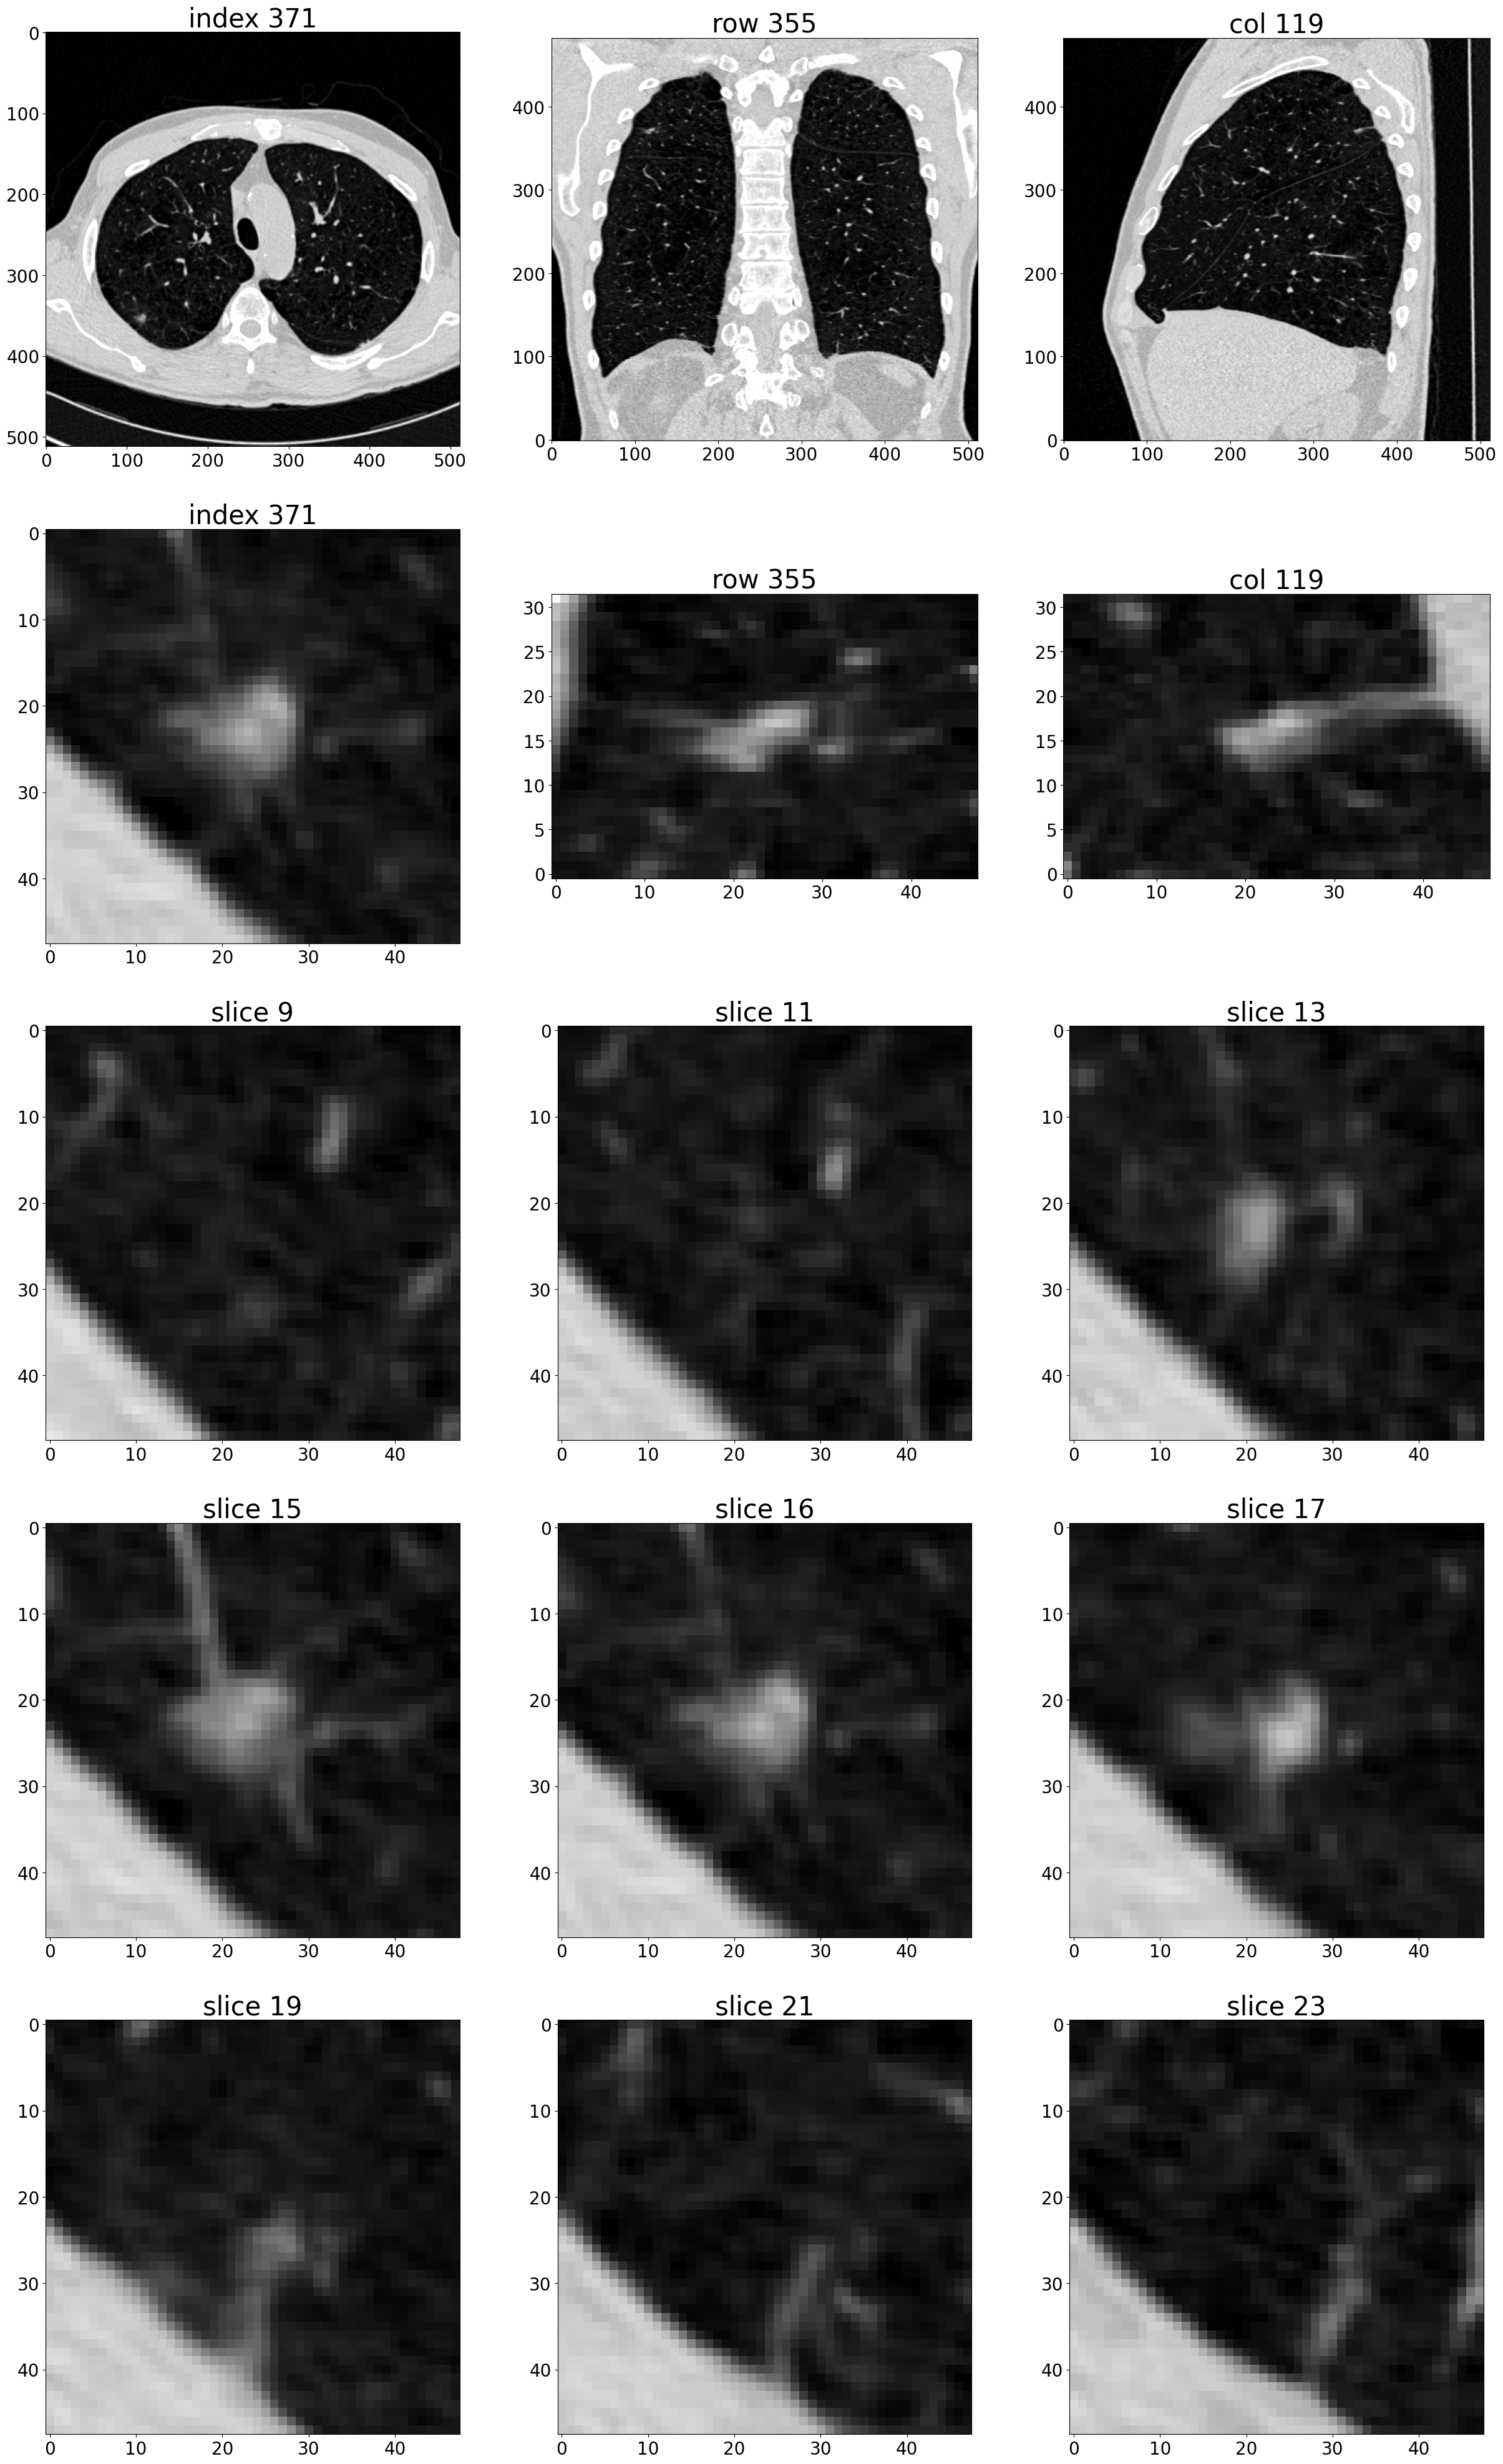

In [3]:
clim=(-1000.0, 300)

def showCandidate(series_uid, batch_ndx=None, **kwargs):
    ds = LunaDataset(series_uid=series_uid, **kwargs)
    pos_list = [i for i, x in enumerate(ds.candidateInfo_list) if x.isNodule_bool]

    if batch_ndx is None:
        if pos_list:
            batch_ndx = pos_list[0]
        else:
            print("Warning: no positive samples found; using first negative sample.")
            batch_ndx = 0

    ct = Ct(series_uid)
    ct_t, pos_t, series_uid, center_irc = ds[batch_ndx]
    ct_a = ct_t[0].numpy()

    fig = plt.figure(figsize=(30, 50))

    group_list = [
        [9, 11, 13],
        [15, 16, 17],
        [19, 21, 23],
    ]
    print(ct.hu_a.shape)
    subplot = fig.add_subplot(len(group_list) + 2, 3, 1)
    subplot.set_title('index {}'.format(int(center_irc[0])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[int(center_irc[0])], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 2)
    subplot.set_title('row {}'.format(int(center_irc[1])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[:,int(center_irc[1])], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 3)
    subplot.set_title('col {}'.format(int(center_irc[2])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[:,:,int(center_irc[2])], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 4)
    subplot.set_title('index {}'.format(int(center_irc[0])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[ct_a.shape[0]//2], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 5)
    subplot.set_title('row {}'.format(int(center_irc[1])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,ct_a.shape[1]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 6)
    subplot.set_title('col {}'.format(int(center_irc[2])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,:,ct_a.shape[2]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    for row, index_list in enumerate(group_list):
        for col, index in enumerate(index_list):
            subplot = fig.add_subplot(len(group_list) + 2, 3, row * 3 + col + 7)
            subplot.set_title('slice {}'.format(index), fontsize=30)
            for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
                label.set_fontsize(20)
            plt.imshow(ct_a[index], clim=clim, cmap='gray')


    print(series_uid, batch_ndx, bool(pos_t[0]), pos_list)




showCandidate('1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950')
